Unfortunately, there are some workarounds required.
```
ln -s vtkm/thirdparty/diy/vtkmdiy/ vtkmdiy
ln -s vtkm/thirdparty/taotuple/vtkmtaotuple/ vtkmtaotuple
```

in the 

```
include/vtkm-1.2
```

installation directory. These are normally handled by the `VTKmTargets.cmake` in

```
lib/cmake/vtkm-1.2/
```


In [1]:
//#pragma include_alias("/local/vtk-m/clang/include/vtkm-1.2/vtkm/thirdparty/taotuple/vtkmtaotuple/","vtkmtaotuple")
#include <lodepng_config_cling.h>
#include <vtkm_config_cling.h>

In [2]:
#include <vtkm/cont/DeviceAdapter.h>
#include <vtkm/cont/testing/MakeTestDataSet.h>
#include <vtkm/cont/testing/Testing.h>
#include <vtkm/rendering/Actor.h>
#include <vtkm/rendering/CanvasRayTracer.h>
#include <vtkm/rendering/MapperRayTracer.h>
#include <vtkm/rendering/Scene.h>
#include <vtkm/rendering/View3D.h>
#include <vtkm/cont/ColorTable.h>
#include <vtkm/rendering/testing/RenderTest.h>
#include <vtkm/io/reader/VTKDataSetReader.h>
#include <vtkm/cont/internal/IteratorFromArrayPortal.h>
#include <vtkm/cont/ArrayPortalToIterators.h>
#include <vtkm/cont/DynamicArrayHandle.h>

Use lodepng to save out png instead of pnm so jupyter can read it.


In [3]:
#include <lodepng.h>
template<typename CanvasType>
void convertPng(CanvasType &canvas, std::vector<std::uint8_t> &ImageBuffer)
{
    int width = canvas.GetWidth();
    int height = canvas.GetHeight();
  std::vector<std::uint8_t> PngBuffer(width*height*4);

  using ColorBufferType = vtkm::cont::ArrayHandle<vtkm::Vec<vtkm::Float32, 4>>;

  ColorBufferType::PortalConstControl colorPortal = canvas.GetColorBuffer().GetPortalConstControl();

  for (vtkm::Id yIndex = 0; yIndex < height; yIndex++)
  {
    for (vtkm::Id xIndex = 0; xIndex < width; xIndex++)
    {
      vtkm::Vec<vtkm::Float32, 4> tuple = colorPortal.Get(yIndex * width + xIndex);
      //of << (unsigned char)(tuple[0] * 255);
      //of << (unsigned char)(tuple[1] * 255);
      //of << (unsigned char)(tuple[2] * 255);
        
        std::size_t NewPos = (height - yIndex - 1) * (width * 4) + 4 * xIndex;
        PngBuffer[NewPos + 0] = (unsigned char)(tuple[0] * 255);
        PngBuffer[NewPos + 1] = (unsigned char)(tuple[1] * 255);
        PngBuffer[NewPos + 2] = (unsigned char)(tuple[2] * 255);
        PngBuffer[NewPos + 3] = 255; 

    }
  }
  lodepng::encode(ImageBuffer, PngBuffer, width, height);
//lodepng::save_file(ImageBuffer, fn.c_str());    
}



In [4]:
#include <string>
#include <fstream>

#include "xtl/xbase64.hpp"
#include "nlohmann/json.hpp"

namespace im
{
    struct image
    {
        inline image(){}
        inline image(const std::vector<uint8_t> &png)
        {
            m_buffer.assign(png.begin(), png.end());
        }

        std::string m_buffer;
    };

    nlohmann::json mime_bundle_repr(const image& i)
    {
        auto bundle = nlohmann::json::object();
        bundle["image/png"] = xtl::base64encode(i.m_buffer);
        return bundle;
    }
}

std::unique_ptr<im::image> displayImage = std::unique_ptr<im::image>();


In [5]:
template <typename ViewType>
inline void SetCamera(vtkm::rendering::Camera& camera,
                      const vtkm::Bounds& coordBounds);

template <>
inline void SetCamera<vtkm::rendering::View3D>(vtkm::rendering::Camera& camera,
                                               const vtkm::Bounds& coordBounds)
{
  camera = vtkm::rendering::Camera();
  camera.ResetToBounds(coordBounds);
  camera.Azimuth(static_cast<vtkm::Float32>(45.0));
  camera.Elevation(static_cast<vtkm::Float32>(45.0));
}
template <typename MapperType, typename CanvasType, typename ViewType>
void Render(ViewType& view)
{
  view.Initialize();
  view.Paint();
}


In [6]:
inline vtkm::cont::DataSet readVTKDataSet(const char* fname)
{
  vtkm::cont::DataSet ds;
  vtkm::io::reader::VTKDataSetReader reader(fname);
  try
  {
    ds = reader.ReadDataSet();
  }
  catch (vtkm::io::ErrorIO& e)
  {
    std::string message("Error reading: ");
    message += fname;
    message += ", ";
    message += e.GetMessage();

    VTKM_TEST_FAIL(message.c_str());
  }

  return ds;
}

In [7]:
auto addField(vtkm::cont::DataSet &ds){
    auto cnt = ds.GetField(0).GetData().GetNumberOfValues();
    vtkm::cont::DataSetFieldAdd dsf;
    std::vector<vtkm::Float32> vars(cnt);
    for (int i=0; i<cnt ;i++){
        vars[i] = i/vtkm::Float32(cnt);
    }
        
    
    dsf.AddPointField(ds, "pointvar", vars);

};

[113.504,29.2415,-40.6343]
{ X:[0.0987893..1.63144], Y:[0.027149..0.34988], Z:[0.0131184..0.379522] }


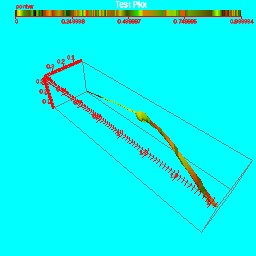

In [8]:
#include <xcpp/xdisplay.hpp>
//anonymous lambda as a work around for redefinition when recompiling
[](){
    
auto buildColorTable = [](const vtkm::cont::DynamicArrayHandle &_h){
    
    auto handle = _h.Cast<vtkm::cont::ArrayHandle<vtkm::Vec<vtkm::Float32,3>>>();
    std::vector<double> out(handle.GetNumberOfValues() * 4);
    for (int i=0; i<handle.GetNumberOfValues(); i++){
        auto tmp = handle.GetPortalConstControl().Get(i);
        out[i*4] = tmp[0];
        out[i*4+1] = tmp[1];
        out[i*4+2] = tmp[2];
        out[i*4+3] = 0.0;
        if (i == 0)
            std::cout << handle.GetPortalConstControl().Get(i) << std::endl;
    }

    std::string name = "inplace";
    vtkm::Vec<double,3> nanIs(0,0,0);
     return vtkm::cont::ColorTable(name, vtkm::cont::ColorSpace::LAB, nanIs, 
                              out);
    
};
    
auto try_and_err = [=]() {

        using M = vtkm::rendering::MapperRayTracer;
using C = vtkm::rendering::CanvasRayTracer;
using V3 = vtkm::rendering::View3D;
using V2 = vtkm::rendering::View2D;

vtkm::cont::testing::MakeTestDataSet maker;


//vtkm::rendering::testing::Render<M, C, V3>(maker.Make3DRegularDataSet0(), "pointvar", colorTable, "rt_reg3D.pnm");

M mapper;
C canvas(256, 256);
vtkm::rendering::Scene scene;
auto ds = readVTKDataSet("edelta-velocity.vtk");
addField(ds);
vtkm::cont::ColorTable colorTable = buildColorTable(ds.GetField(0).GetData());
static std::string fieldNm = "pointvar";

scene.AddActor(vtkm::rendering::Actor(
ds.GetCellSet(), ds.GetCoordinateSystem(), ds.GetField(fieldNm), colorTable));
vtkm::rendering::Camera camera;
SetCamera<V3>(camera, ds.GetCoordinateSystem().GetBounds());
    std::cout << ds.GetCoordinateSystem().GetBounds() << std::endl;
vtkm::rendering::Color background(0.0f, 1.0f, 1.0f, 1.0f);
vtkm::rendering::Color foreground(1.0f, 0.0f, 0.0f, 1.0f);
V3 view(scene, mapper, canvas, camera, background, foreground);

// Print the title
vtkm::rendering::TextAnnotationScreen* titleAnnotation =
new vtkm::rendering::TextAnnotationScreen("Test Plot",
                                          vtkm::rendering::Color(1, 1, 1, 1),
                                          .075f,
                                          vtkm::Vec<vtkm::Float32, 2>(-.11f, .92f),
                                          0.f);
view.AddAnnotation(titleAnnotation);
Render<M, C, V3>(view);

  std::vector<std::uint8_t> png;
  convertPng(canvas, png);
   
  displayImage = std::make_unique<im::image>(png);
  xcpp::display(*displayImage);
};
    try_and_err();
}();